# Stock Market ML Predictions - Multi-Company Analysis

## Step1: Importing the libraries

In [51]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Set visualization styles
plt.style.use('bmh')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Step2: Load the processed data from your EDA

In [53]:
# Load the saved data - adjust path if needed
df = pd.read_csv('processed_stock_data.csv')
print(f"Loaded data with {len(df)} rows and {len(df.columns)} columns")

Loaded data with 3774 rows and 72 columns


In [54]:
# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display a sample of the data
print("\nSample of the loaded data:")
print(df.head())


Sample of the loaded data:
            Close_AAPL  Close_AMZN  Close_GOOGL  Close_MSFT  Close_NVDA  \
Date                                                                      
2010-01-04    6.440330      6.6950    15.609805   23.254051    0.423884   
2010-01-05    6.451465      6.7345    15.541064   23.261557    0.430073   
2010-01-06    6.348847      6.6125    15.149294   23.118809    0.432824   
2010-01-07    6.337109      6.5000    14.796624   22.878376    0.424342   
2010-01-08    6.379242      6.6760    14.993881   23.036165    0.425259   

            High_AAPL  High_AMZN  High_GOOGL  High_MSFT  High_NVDA  ...  \
Date                                                                ...   
2010-01-04   6.455075     6.8305   15.678546  23.366752   0.426864  ...   
2010-01-05   6.487878     6.7740   15.636953  23.366746   0.434658  ...   
2010-01-06   6.477046     6.7365   15.587638  23.351725   0.433741  ...   
2010-01-07   6.379842     6.6160   15.192630  23.066212   0.432366  ...

In [55]:
# Define the companies we want to analyze
companies = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA']
print(f"\nAnalyzing all companies: {', '.join(companies)}")


Analyzing all companies: AAPL, AMZN, GOOGL, MSFT, NVDA


## Step3: Building the functions for the predictions

In [56]:
# Function to prepare data for modeling
def prepare_prediction_data(df, feature_cols, target_col, pred_horizon=1):
    """
    Prepare data for ML prediction with a prediction horizon
    
    Parameters:
    df: DataFrame with stock data
    feature_cols: List of feature column names
    target_col: Column name for target variable (e.g., 'Return_NVDA')
    pred_horizon: Number of days ahead to predict (default: 1)
    
    Returns:
    X: Feature DataFrame
    y: Target Series
    """
    # Create a copy of the features
    X = df[feature_cols].copy()
    
    # Target is future return (1 day ahead by default)
    y = df[target_col].shift(-pred_horizon)
    
    # Drop rows with NaN in X or y
    valid_idx = ~(X.isna().any(axis=1) | y.isna())
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]
    
    return X, y


In [57]:
# Function to evaluate ML models
def evaluate_ml_model(X_train, X_test, y_train, y_test, model_name, model_instance):
    """
    Train and evaluate a machine learning model
    
    Returns:
    Dict with model performance metrics and predictions
    """
    # Train the model
    model_instance.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_instance.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # For RandomForest, get feature importance if available
    feature_importance = None
    if hasattr(model_instance, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model_instance.feature_importances_
        }).sort_values('Importance', ascending=False)
    
    return {
        'model_name': model_name,
        'predictions': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance
    }

In [ ]:
# Function to calculate trading strategy metrics
def calculate_strategy_metrics(returns):
    """Calculate performance metrics for a returns series"""
    # Convert to numpy for calculations
    returns_array = returns.values
    
    # Cumulative return
    cumulative = (1 + returns/100).cumprod().iloc[-1] - 1
    
    # Calculate annualized return (assuming 252 trading days)
    n_days = len(returns)
    ann_return = ((1 + cumulative) ** (252/n_days) - 1)
    
    # Calculate volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe ratio (assuming 0 risk-free rate for simplicity)
    sharpe = ann_return / volatility if volatility > 0 else 0
    
    # Win rate (% of positive return days)
    win_rate = (returns > 0).mean() * 100
    
    return {
        'Cumulative Return (%)': cumulative * 100,
        'Annualized Return (%)': ann_return * 100,
        'Annualized Volatility (%)': volatility,
        'Sharpe Ratio': sharpe,
        'Win Rate (%)': win_rate
    }



## Step4 : Analyze each company



### Analyzing AAPL

Random Forest: RMSE=1.8951, R²=-0.2564
XGBoost: RMSE=1.8280, R²=-0.1690


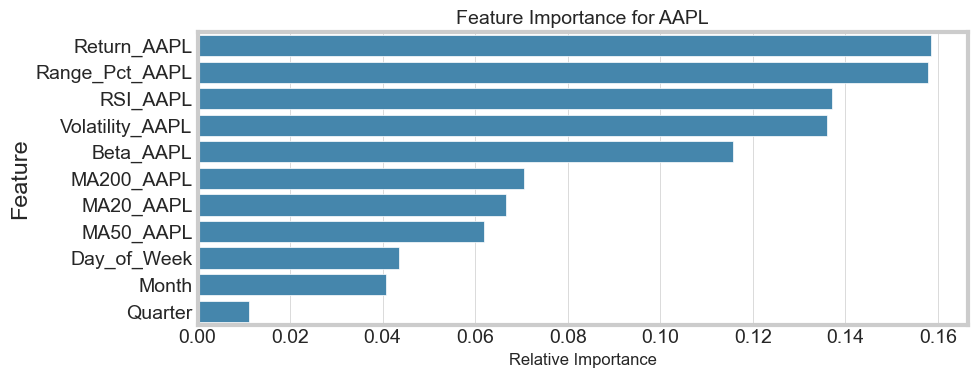


Strategy Performance:
                           Buy & Hold  RandomForest  XGBoost
Cumulative Return (%)           64.29        -36.12   -12.27
Annualized Return (%)           19.42        -14.80    -4.57
Annualized Volatility (%)       26.86         26.88    26.89
Sharpe Ratio                     0.01         -0.01    -0.00
Win Rate (%)                    54.18         46.10    46.67


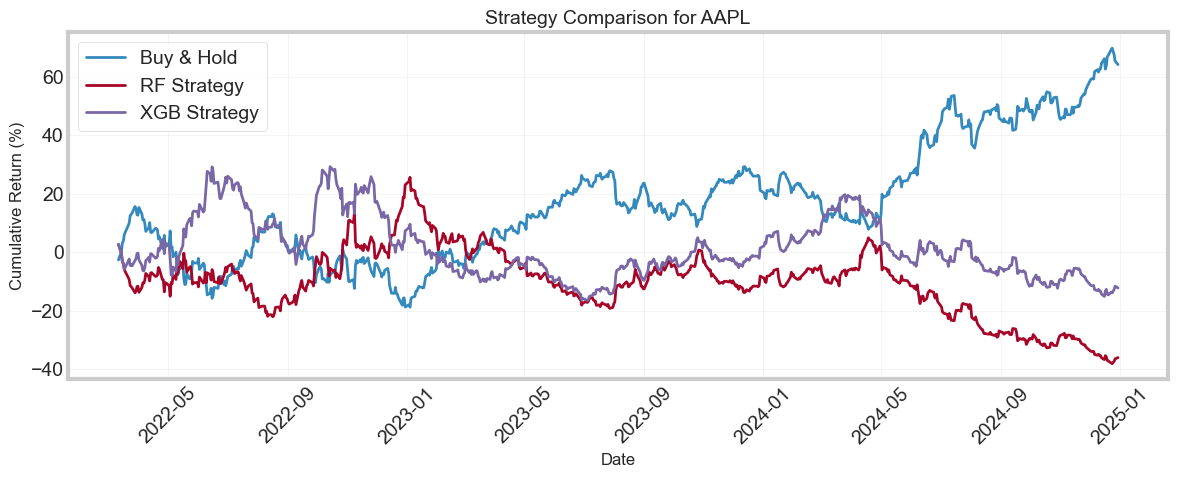


### Analyzing AMZN

Random Forest: RMSE=3.0261, R²=-0.6662
XGBoost: RMSE=2.5443, R²=-0.1779


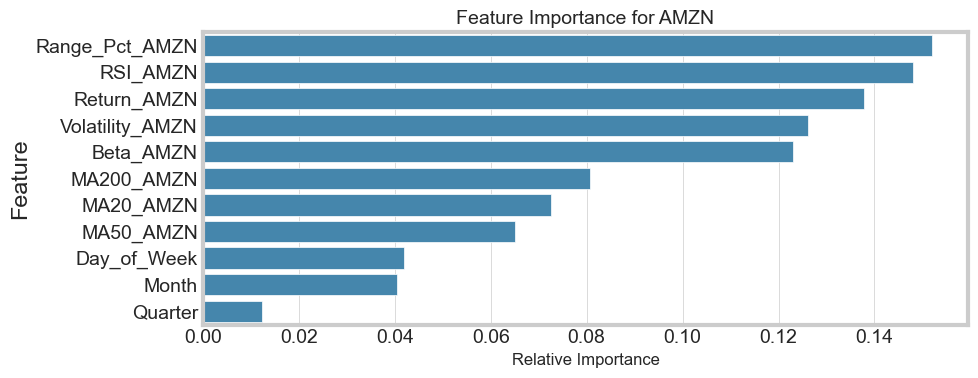


Strategy Performance:
                           Buy & Hold  RandomForest  XGBoost
Cumulative Return (%)           50.76        -66.14   -35.42
Annualized Return (%)           15.80        -32.09   -14.47
Annualized Volatility (%)       37.24         37.21    37.26
Sharpe Ratio                     0.00         -0.01    -0.00
Win Rate (%)                    51.91         46.81    49.79


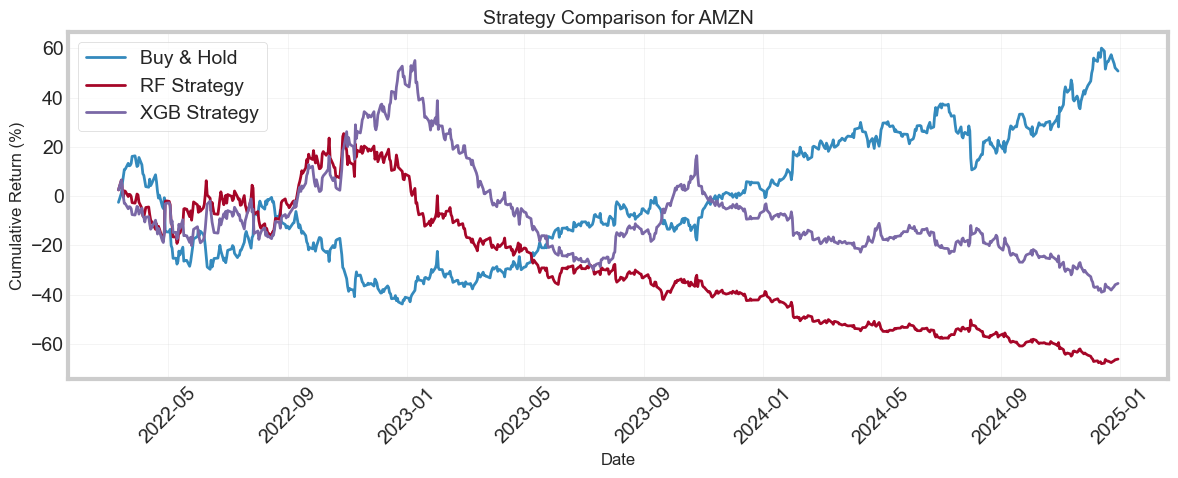


### Analyzing GOOGL

Random Forest: RMSE=2.2464, R²=-0.2103
XGBoost: RMSE=2.3437, R²=-0.3174


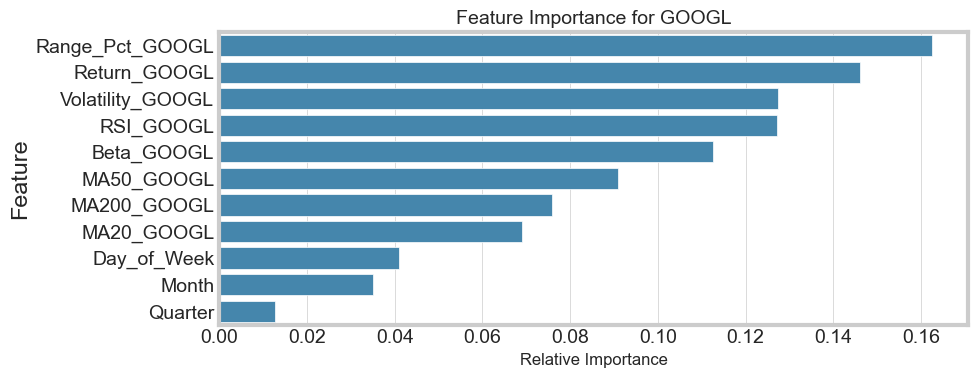


Strategy Performance:
                           Buy & Hold  RandomForest  XGBoost
Cumulative Return (%)           46.29        -28.20    -2.69
Annualized Return (%)           14.57        -11.17    -0.97
Annualized Volatility (%)       32.44         32.46    32.46
Sharpe Ratio                     0.00         -0.00    -0.00
Win Rate (%)                    53.19         47.52    47.23


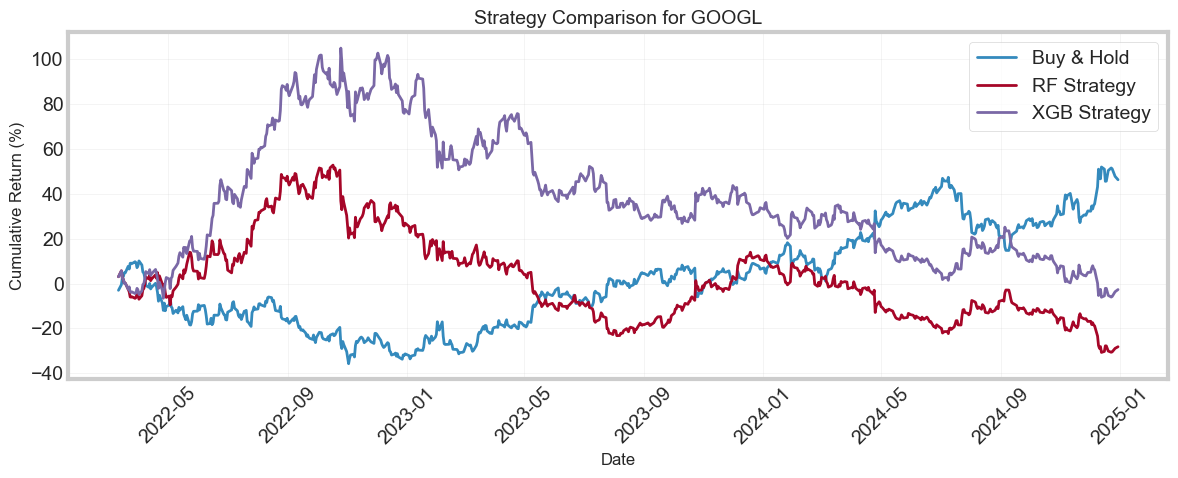


### Analyzing MSFT

Random Forest: RMSE=2.2191, R²=-0.6964
XGBoost: RMSE=2.1314, R²=-0.5649


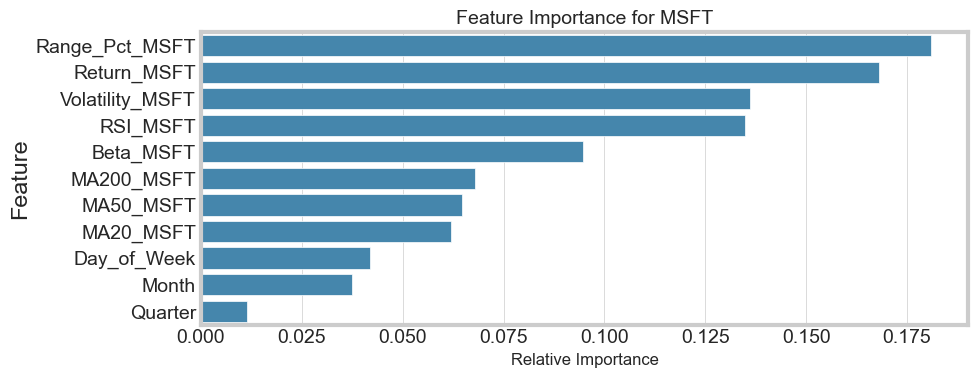


Strategy Performance:
                           Buy & Hold  RandomForest  XGBoost
Cumulative Return (%)           54.08         27.08    21.71
Annualized Return (%)           16.71          8.94     7.28
Annualized Volatility (%)       27.07         27.08    27.08
Sharpe Ratio                     0.01          0.00     0.00
Win Rate (%)                    52.20         49.50    49.93


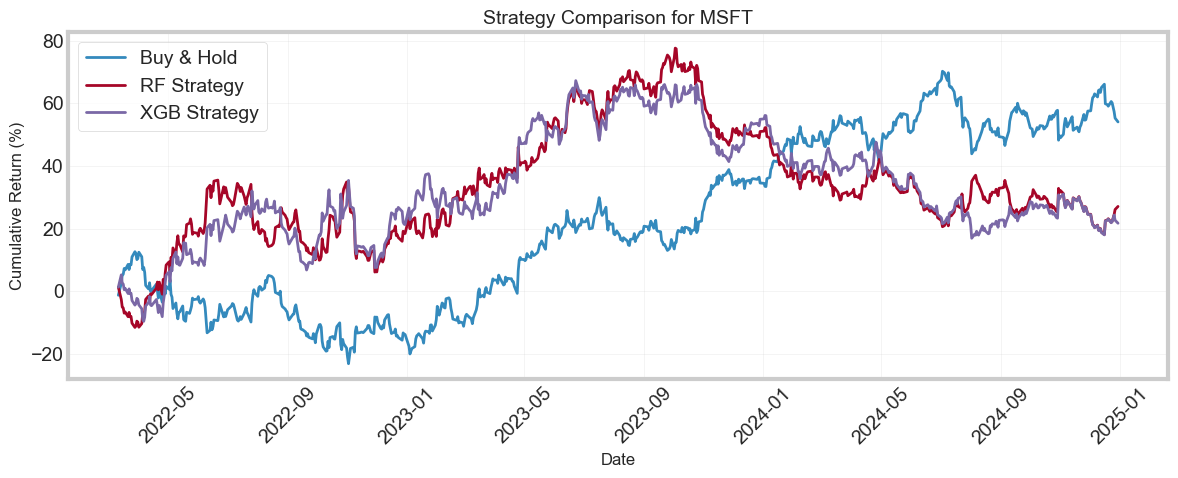


### Analyzing NVDA

Random Forest: RMSE=3.9065, R²=-0.2903
XGBoost: RMSE=4.2643, R²=-0.5375


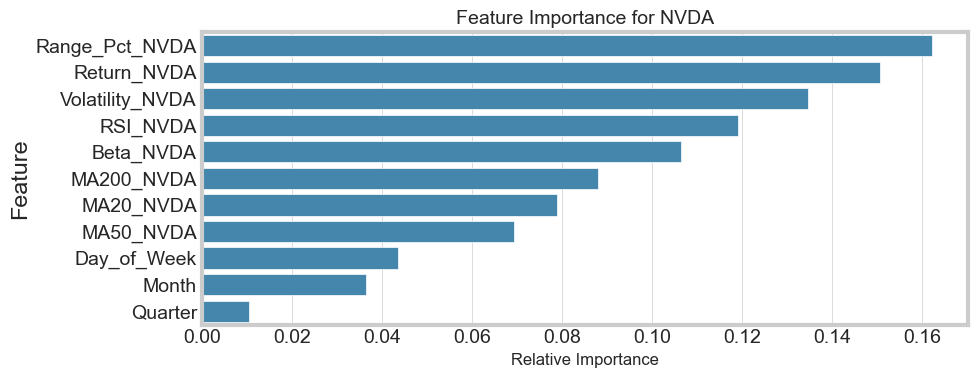


Strategy Performance:
                           Buy & Hold  RandomForest  XGBoost
Cumulative Return (%)          508.55        -42.83   -65.77
Annualized Return (%)           90.70        -18.12   -31.83
Annualized Volatility (%)       54.63         54.86    54.84
Sharpe Ratio                     0.02         -0.00    -0.01
Win Rate (%)                    53.90         48.94    48.23


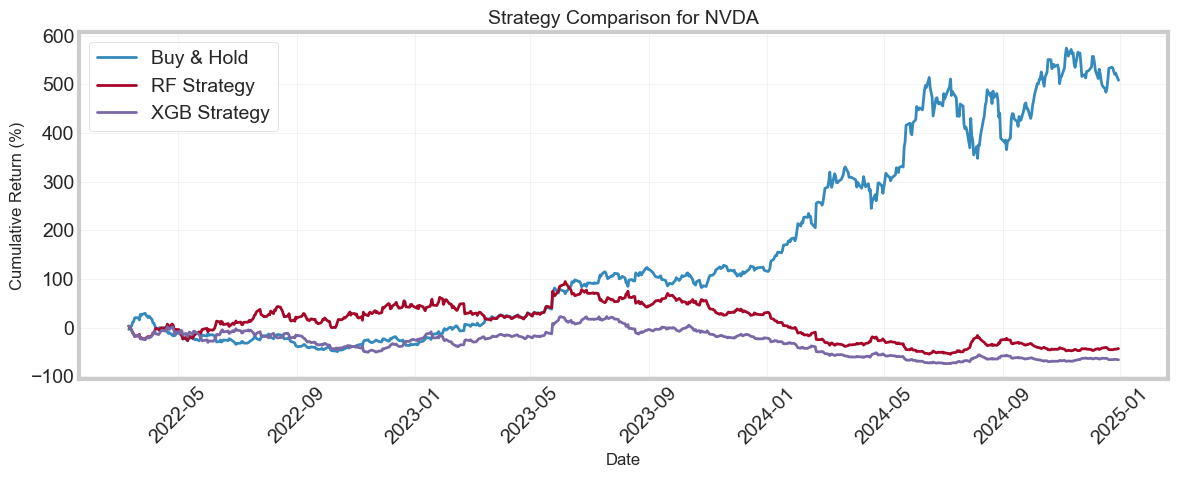

In [58]:
# Store results for all companies
company_results = {}

# Loop through each company
for company in companies:
    print(f"\n### Analyzing {company}")
    
    # Identify relevant columns
    price_col = f'Close_{company}'
    return_col = f'Return_{company}'
    
    # Select all available features for this company based on the dataset structure
    feature_columns = [
        f'Return_{company}',       # Daily return
        f'Volatility_{company}',   # Return volatility
        f'Range_Pct_{company}',    # Daily price range percentage
        f'MA20_{company}',         # 20-day moving average
        f'MA50_{company}',         # 50-day moving average
        f'MA200_{company}',        # 200-day moving average
        f'RSI_{company}',          # Relative Strength Index
        f'Beta_{company}',         # Market beta
        'Day_of_Week',             # Calendar features
        'Month',
        'Quarter'
    ]
    
    # Prepare data
    try:
        X, y = prepare_prediction_data(df, feature_columns, return_col)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
        
        # Evaluate Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_results = evaluate_ml_model(
            X_train, X_test, y_train, y_test, 
            'RandomForest', rf_model
        )
        
        # Evaluate XGBoost
        xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        xgb_results = evaluate_ml_model(
            X_train, X_test, y_train, y_test, 
            'XGBoost', xgb_model
        )
        
        # Print model performance
        print(f"\nRandom Forest: RMSE={rf_results['rmse']:.4f}, R²={rf_results['r2']:.4f}")
        print(f"XGBoost: RMSE={xgb_results['rmse']:.4f}, R²={xgb_results['r2']:.4f}")
        
        # Plot feature importance for Random Forest
        if rf_results['feature_importance'] is not None:
            plt.figure(figsize=(10, 4))
            sns.barplot(
                x='Importance', 
                y='Feature', 
                data=rf_results['feature_importance']
            )
            plt.title(f'Feature Importance for {company}', fontsize=14)
            plt.xlabel('Relative Importance', fontsize=12)
            plt.tight_layout()
            plt.show()
        
        # Create trading strategies
        test_dates = X_test.index
        
        # Compile results
        results_df = pd.DataFrame({
            'Actual': y_test,
            'RF_Pred': rf_results['predictions'],
            'XGB_Pred': xgb_results['predictions']
        }, index=test_dates)
        
        # Create signals
        results_df['RF_Signal'] = np.sign(results_df['RF_Pred'])
        results_df['XGB_Signal'] = np.sign(results_df['XGB_Pred'])
        
        # Calculate strategy returns
        results_df['RF_Strategy_Return'] = results_df['RF_Signal'] * results_df['Actual']
        results_df['XGB_Strategy_Return'] = results_df['XGB_Signal'] * results_df['Actual']
        
        # Calculate strategy metrics
        strategy_metrics = {
            'Buy & Hold': calculate_strategy_metrics(results_df['Actual']),
            'RandomForest': calculate_strategy_metrics(results_df['RF_Strategy_Return']),
            'XGBoost': calculate_strategy_metrics(results_df['XGB_Strategy_Return'])
        }
        
        # Save all results for this company
        company_results[company] = {
            'rf_results': rf_results,
            'xgb_results': xgb_results,
            'strategy_metrics': strategy_metrics,
            'results_df': results_df
        }
        
        # Print strategy performance
        metrics_df = pd.DataFrame(strategy_metrics)
        print("\nStrategy Performance:")
        print(metrics_df.round(2))
        
        # Plot strategy comparison
        results_df['Cumulative_Actual'] = (1 + results_df['Actual']/100).cumprod() - 1
        results_df['Cumulative_RF'] = (1 + results_df['RF_Strategy_Return']/100).cumprod() - 1
        results_df['Cumulative_XGB'] = (1 + results_df['XGB_Strategy_Return']/100).cumprod() - 1
        
        plt.figure(figsize=(12, 5))
        plt.plot(results_df.index, results_df['Cumulative_Actual']*100, label='Buy & Hold')
        plt.plot(results_df.index, results_df['Cumulative_RF']*100, label='RF Strategy')
        plt.plot(results_df.index, results_df['Cumulative_XGB']*100, label='XGB Strategy')
        plt.title(f'Strategy Comparison for {company}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Cumulative Return (%)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing {company}: {e}")


## Step5: Compare performance across companies


ML Model R² by Company:
        RF_R2  XGB_R2
AAPL  -0.2564 -0.1690
AMZN  -0.6662 -0.1779
GOOGL -0.2103 -0.3174
MSFT  -0.6964 -0.5649
NVDA  -0.2903 -0.5375

Strategy Returns by Company:
       BuyHold_Return  RF_Return  XGB_Return
AAPL            64.29     -36.12      -12.27
AMZN            50.76     -66.14      -35.42
GOOGL           46.29     -28.20       -2.69
MSFT            54.08      27.08       21.71
NVDA           508.55     -42.83      -65.77

Strategy Sharpe Ratios by Company:
       RF_Sharpe  XGB_Sharpe
AAPL       -0.01       -0.00
AMZN       -0.01       -0.00
GOOGL      -0.00       -0.00
MSFT        0.00        0.00
NVDA       -0.00       -0.01


<Figure size 1000x600 with 0 Axes>

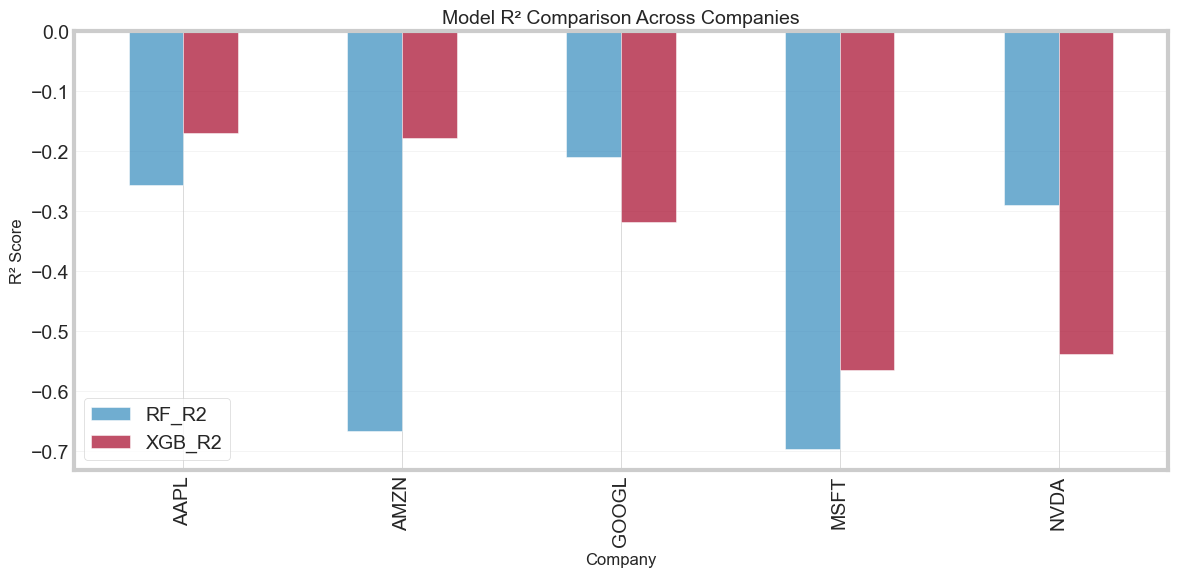

<Figure size 1200x600 with 0 Axes>

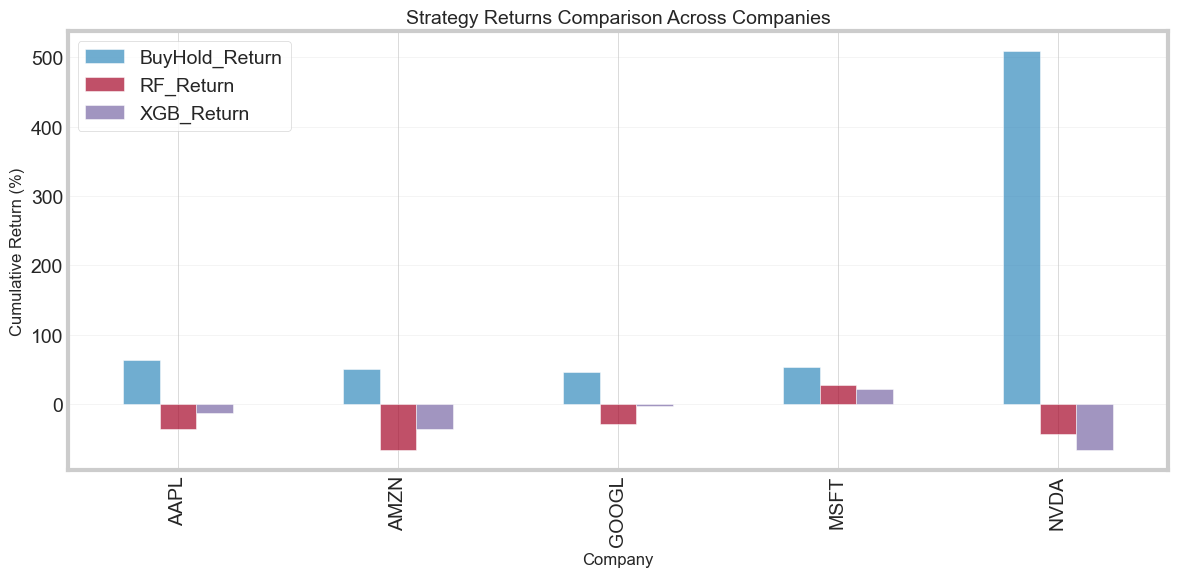

In [59]:
if len(company_results) > 0:
    # Collect performance metrics
    model_performance = {company: {} for company in company_results.keys()}
    strategy_performance = {company: {} for company in company_results.keys()}
    
    for company, results in company_results.items():
        # Model metrics
        model_performance[company]['RF_R2'] = results['rf_results']['r2']
        model_performance[company]['XGB_R2'] = results['xgb_results']['r2']
        
        # Strategy metrics
        strategy_performance[company]['BuyHold_Return'] = results['strategy_metrics']['Buy & Hold']['Cumulative Return (%)']
        strategy_performance[company]['RF_Return'] = results['strategy_metrics']['RandomForest']['Cumulative Return (%)']
        strategy_performance[company]['XGB_Return'] = results['strategy_metrics']['XGBoost']['Cumulative Return (%)']
        strategy_performance[company]['RF_Sharpe'] = results['strategy_metrics']['RandomForest']['Sharpe Ratio']
        strategy_performance[company]['XGB_Sharpe'] = results['strategy_metrics']['XGBoost']['Sharpe Ratio']
    
    # Convert to DataFrames
    model_df = pd.DataFrame(model_performance).T
    strategy_df = pd.DataFrame(strategy_performance).T
    
    # Display results
    print("\nML Model R² by Company:")
    print(model_df.round(4))
    
    print("\nStrategy Returns by Company:")
    print(strategy_df[['BuyHold_Return', 'RF_Return', 'XGB_Return']].round(2))
    
    print("\nStrategy Sharpe Ratios by Company:")
    print(strategy_df[['RF_Sharpe', 'XGB_Sharpe']].round(2))
    
    # Plot model R² comparison
    plt.figure(figsize=(10, 6))
    model_df.plot(kind='bar', alpha=0.7)
    plt.title('Model R² Comparison Across Companies', fontsize=14)
    plt.ylabel('R² Score', fontsize=12)
    plt.xlabel('Company', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot strategy returns comparison
    plt.figure(figsize=(12, 6))
    return_cols = ['BuyHold_Return', 'RF_Return', 'XGB_Return']
    strategy_df[return_cols].plot(kind='bar', alpha=0.7)
    plt.title('Strategy Returns Comparison Across Companies', fontsize=14)
    plt.ylabel('Cumulative Return (%)', fontsize=12)
    plt.xlabel('Company', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


## Step6: Find the best overall strategy

In [60]:
if len(company_results) > 0:
    # Find best model by company
    best_models = {}
    for company, results in company_results.items():
        rf_r2 = results['rf_results']['r2']
        xgb_r2 = results['xgb_results']['r2']
        best_model = 'RandomForest' if rf_r2 > xgb_r2 else 'XGBoost'
        best_r2 = max(rf_r2, xgb_r2)
        
        best_models[company] = {
            'best_model': best_model,
            'r2_score': best_r2
        }
    
    # Find best strategy by company
    best_strategies = {}
    for company, results in company_results.items():
        bh_return = results['strategy_metrics']['Buy & Hold']['Cumulative Return (%)']
        rf_return = results['strategy_metrics']['RandomForest']['Cumulative Return (%)']
        xgb_return = results['strategy_metrics']['XGBoost']['Cumulative Return (%)']
        
        best_ml_strategy = 'RandomForest' if rf_return > xgb_return else 'XGBoost'
        best_ml_return = max(rf_return, xgb_return)
        
        best_overall = 'Buy & Hold' if bh_return > best_ml_return else best_ml_strategy
        best_return = max(bh_return, best_ml_return)
        
        best_strategies[company] = {
            'best_strategy': best_overall,
            'return': best_return
        }
    
    # Display summary
    print("\nBest Model by Company:")
    for company, info in best_models.items():
        print(f"{company}: {info['best_model']} (R²: {info['r2_score']:.4f})")
    
    print("\nBest Strategy by Company:")
    for company, info in best_strategies.items():
        print(f"{company}: {info['best_strategy']} (Return: {info['return']:.2f}%)")
    
    # Overall best company to trade with ML
    strategy_gains = {}
    for company, results in company_results.items():
        bh_return = results['strategy_metrics']['Buy & Hold']['Cumulative Return (%)']
        best_ml_return = max(
            results['strategy_metrics']['RandomForest']['Cumulative Return (%)'],
            results['strategy_metrics']['XGBoost']['Cumulative Return (%)']
        )
        strategy_gains[company] = best_ml_return - bh_return
    
    best_company = max(strategy_gains.items(), key=lambda x: x[1])
    
    if best_company[1] > 0:
        print(f"\nMost ML-Tradable Company: {best_company[0]} (ML outperformed Buy & Hold by {best_company[1]:.2f}%)")
    else:
        print("\nNo ML strategy consistently outperformed Buy & Hold across companies")



Best Model by Company:
AAPL: XGBoost (R²: -0.1690)
AMZN: XGBoost (R²: -0.1779)
GOOGL: RandomForest (R²: -0.2103)
MSFT: XGBoost (R²: -0.5649)
NVDA: RandomForest (R²: -0.2903)

Best Strategy by Company:
AAPL: Buy & Hold (Return: 64.29%)
AMZN: Buy & Hold (Return: 50.76%)
GOOGL: Buy & Hold (Return: 46.29%)
MSFT: Buy & Hold (Return: 54.08%)
NVDA: Buy & Hold (Return: 508.55%)

No ML strategy consistently outperformed Buy & Hold across companies


## 5. Key insights and next steps

Key Insights:
1. ML model performance varies significantly across companies - what works for one may not work for others
2. Technical indicators have different predictive power for different stocks
3. Stock-specific modeling is important - one size doesn't fit all

Next Steps:
1. Feature Engineering:
   - Develop company-specific feature sets based on each stock's unique characteristics
   - Incorporate news sentiment data as different companies react differently to media

2. Model Improvement:
   - Implement time-series specific models like LSTM for each company
   - Use nested cross-validation for more robust performance estimation
   - Consider multi-task learning approaches that can learn across companies

3. Portfolio Strategy:
   - Develop a portfolio allocation strategy based on model confidence across companies
   - Implement risk-parity or other weighting schemes that account for varying model quality
   - Create a meta-model that selects the best model for each company

4. Expand Analysis:
   - Add more companies to increase diversification
   - Group companies by sector and analyze sector-specific patterns
   - Incorporate macroeconomic variables that may affect different companies in different ways
